**Adapted from `plot_nested_cross_validation_iris.ipynb` notebook provided as part of UoL's DS MSc module DSM040 Machine Learning (April 2021 session), originally from SKLearn: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html**

# Nested versus non-nested cross-validation

This notebook explores the difference between nested and non-nested cross-validation (CV) for model tuning. It uses a support-vector classifier (SVC) and a non-linear kernel to classify the iris dataset. Performance of nested and non-nested CV are compared.

Nested cross-validation is commonly used to optimise the hyperparamenters of a model. According to SKLearn: "Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search. Choosing the parameters that maximize non-nested CV biases the model to the dataset, yielding an overly-optimistic score." [[1]](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html).

If model selection and optimisation are carried out with non-nested CV, the same data is used during cross-validation to tune hyperparameters and evaluate performance, which can lead to overfitting due to data leakage. The degree to which this is an issue depends on "the size of the dataset and the stability of the model" \[[2](http://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf), cited [1](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)\].

A more robust approach is to carry out nested CV, which uses a series of train/validation/test splits of the data, within inner and outer loops.
The inner loop,
:class:`GridSearchCV <sklearn.model_selection.GridSearchCV>` in the code below,
fits a model on each training set, appropriately maximising the score, and then directly optimises the score by optimising hyperparameters over the validation set.
The outer loop,
:func:`cross_val_score <sklearn.model_selection.cross_val_score>` in the code below,
averages test-set scores over multiple data-splits to generate the generalisation error.

### References:

[1] SKLearn, 'Nested versus non-nested cross-validation'. scikit-learn.org. <https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html>

[2] Cawley, G.C.; Talbot, N.L.C. 'On over-fitting in model selection and subsequent selection bias in performance evaluation'. J. Mach. Learn. Res 2010,11, 2079-2107. <http://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf>

In [1]:
# Import libraries 
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

In [3]:
# Define number of random trials
num_trials = 30

# Set up possible values of parameters to optimize over
p_grid = {'C': [1, 10, 100],
          'gamma': [.01, .1]}

# Use a Support Vector Classifier with "rbf" kernel
svc = SVC(kernel='rbf')

# Create arrays in which to store scores
non_nested_scores = np.zeros(num_trials)
nested_scores = np.zeros(num_trials)

# Loop for each trial
for i in range(num_trials):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # e.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    # Use i to define random_state, ensuring a different split each time
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non-nested CV parameter search and scoring
    clf = GridSearchCV(estimator=svc, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV parameter search and scoring
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

# Calc. difference
score_difference = non_nested_scores - nested_scores

print('Average difference of {:6f} with standard deviation of {:6f}.'
      .format(score_difference.mean(), score_difference.std()))

Average difference of 0.007581 with standard deviation of 0.007833.


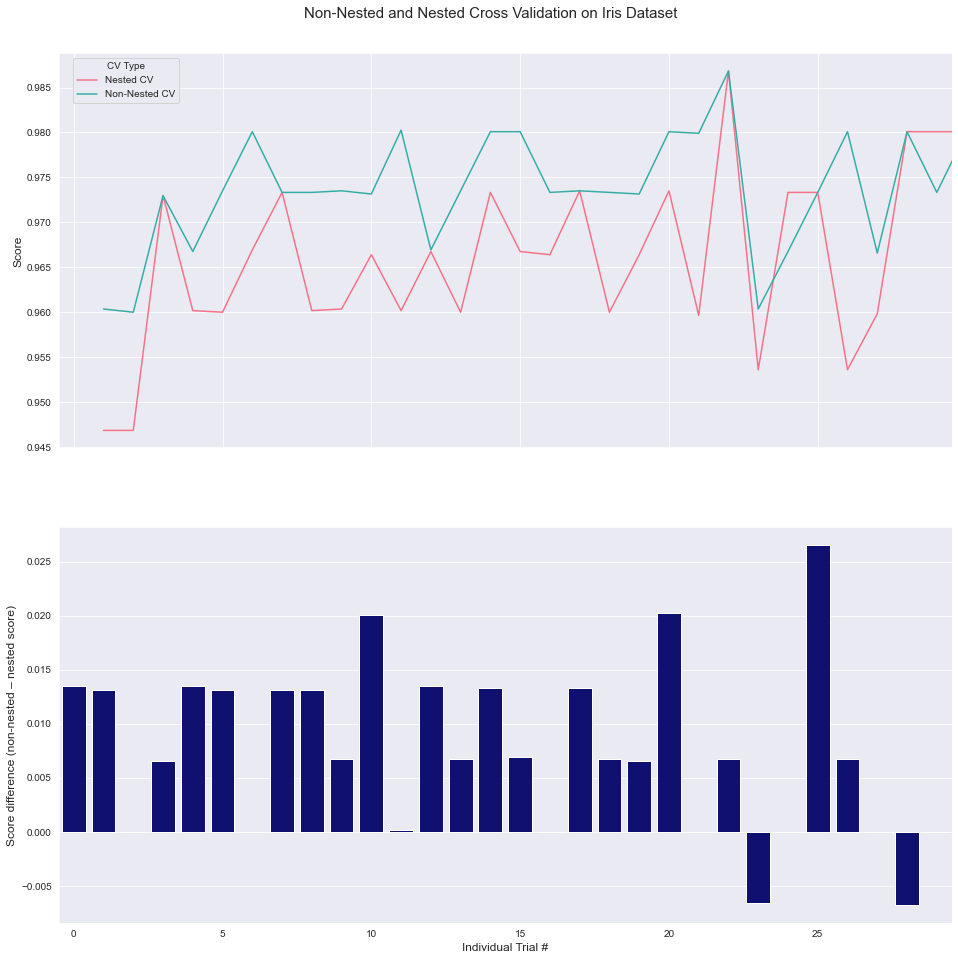

In [4]:
# Create pandas df for Seaborn plotting
nested_scores_2 = [(x, i+1, 'nested') for i, x in enumerate(nested_scores)]
non_nested_scores_2 = [(x, i+1, 'non_nested') for i, x in enumerate(non_nested_scores)]
all_scores = nested_scores_2+non_nested_scores_2
df = pd.DataFrame(all_scores, columns=['score', 'trial_num', 'cv_type'])

# Set Seaborn style
sns.set_style('darkgrid')

# Plot scores on each trial for nested and non-nested CV
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16,16), sharex=True)
fig.suptitle('Non-Nested and Nested Cross Validation on Iris Dataset', 
            x=0.5, y=0.92, fontsize='15')

# Plot scores
ax1.set(xlabel=None)
scores_lineplot = sns.lineplot(data=df, x='trial_num', y='score', \
                               hue='cv_type', palette='husl', ax=ax1)
scores_lineplot.legend(bbox_to_anchor=(0.14, 1, 0.0, 0.0), \
                       labels=['Nested CV', 'Non-Nested CV'], title='CV Type')
scores_lineplot.set_ylabel('Score', fontsize='12')

# Plot bar chart of score difference
differences = [x-y for (x,y) in zip(non_nested_scores, nested_scores)]
difference_plot = sns.barplot(x=[i for i,x in enumerate(differences)], \
                              y=differences, color='navy', ax=ax2)
difference_plot.set_xticks(np.arange(0, len(differences), 5.0))
difference_plot.set_ylabel('Score difference (non-nested – nested score)', fontsize='12')
difference_plot.set_xlabel('Individual Trial #', fontsize='12')
plt.show()